<a href="https://colab.research.google.com/github/Sonchecho/DataScience300/blob/main/Taller_2_machine_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Taller #2 Aplicación de métodos de segmentacion 

**Liberias**

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

**Funciones**

In [ ]:
def Pendiete(X,y):
    size = len(X)
    m = (y[0]-y[-1])/(X[0]-X[-1])
    return m
    
def Recta_Tendencia(X,y,m):
    z = m*X -m*X[-1] + y[-1]
    return z

Descargamos de yahoo finance el valor de las acciones de Mcdonalds desde el 25 de Enero 2002 hata 26 de Marzo de 2021. A continuación importamos los datos

In [ ]:
accion = pd.read_csv('MCD.csv')
precio = accion[['Date','Close']]
print(precio.columns)
precio = precio[precio.index < 5000]

Index(['Date', 'Close'], dtype='object')


A continuación mostramos la grafica de la evolución del precio de facebook desde el 2012 hasta el año 2021

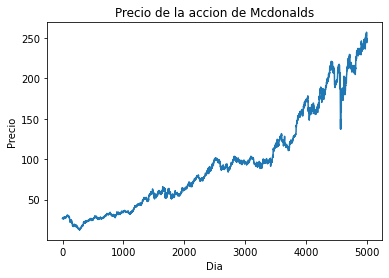

In [ ]:
plt.plot(precio['Close'])
plt.title('Precio de la accion de Mcdonalds')
plt.xlabel('Dia')
plt.ylabel('Precio')
plt.show()

Tenemos 5000 datos los cuales vamos a dividir cada 50 datos para enocontrar las pendientes usando métodos de regresión

In [ ]:
lista_precios = list(precio['Close'])
muestras = []
N = len(precio)
aux = range(0,N+1,50)
for muestra in range(0,len(aux)-1):
    muestras.append(lista_precios[aux[muestra]:aux[muestra+1]])

Es decir que tenemos un conjunto de datos  de 100 muestras a las cuales le aplicaremos una regresión con k-vecinos mas cercanos para encontrar la pendiete que se necesita. Ahora como el valor de la acción es tan viariable es decir tiene tanta volatilidad, entonces se necesita un regresor que trate de capturar dicho comportamiento, por lo que se escoge el número minimo de vecinos que es 2. Además usando la ecuación de la recta, se gráfica la linea de tendencia que tiene el conjunto de datos, de la siguiente manera

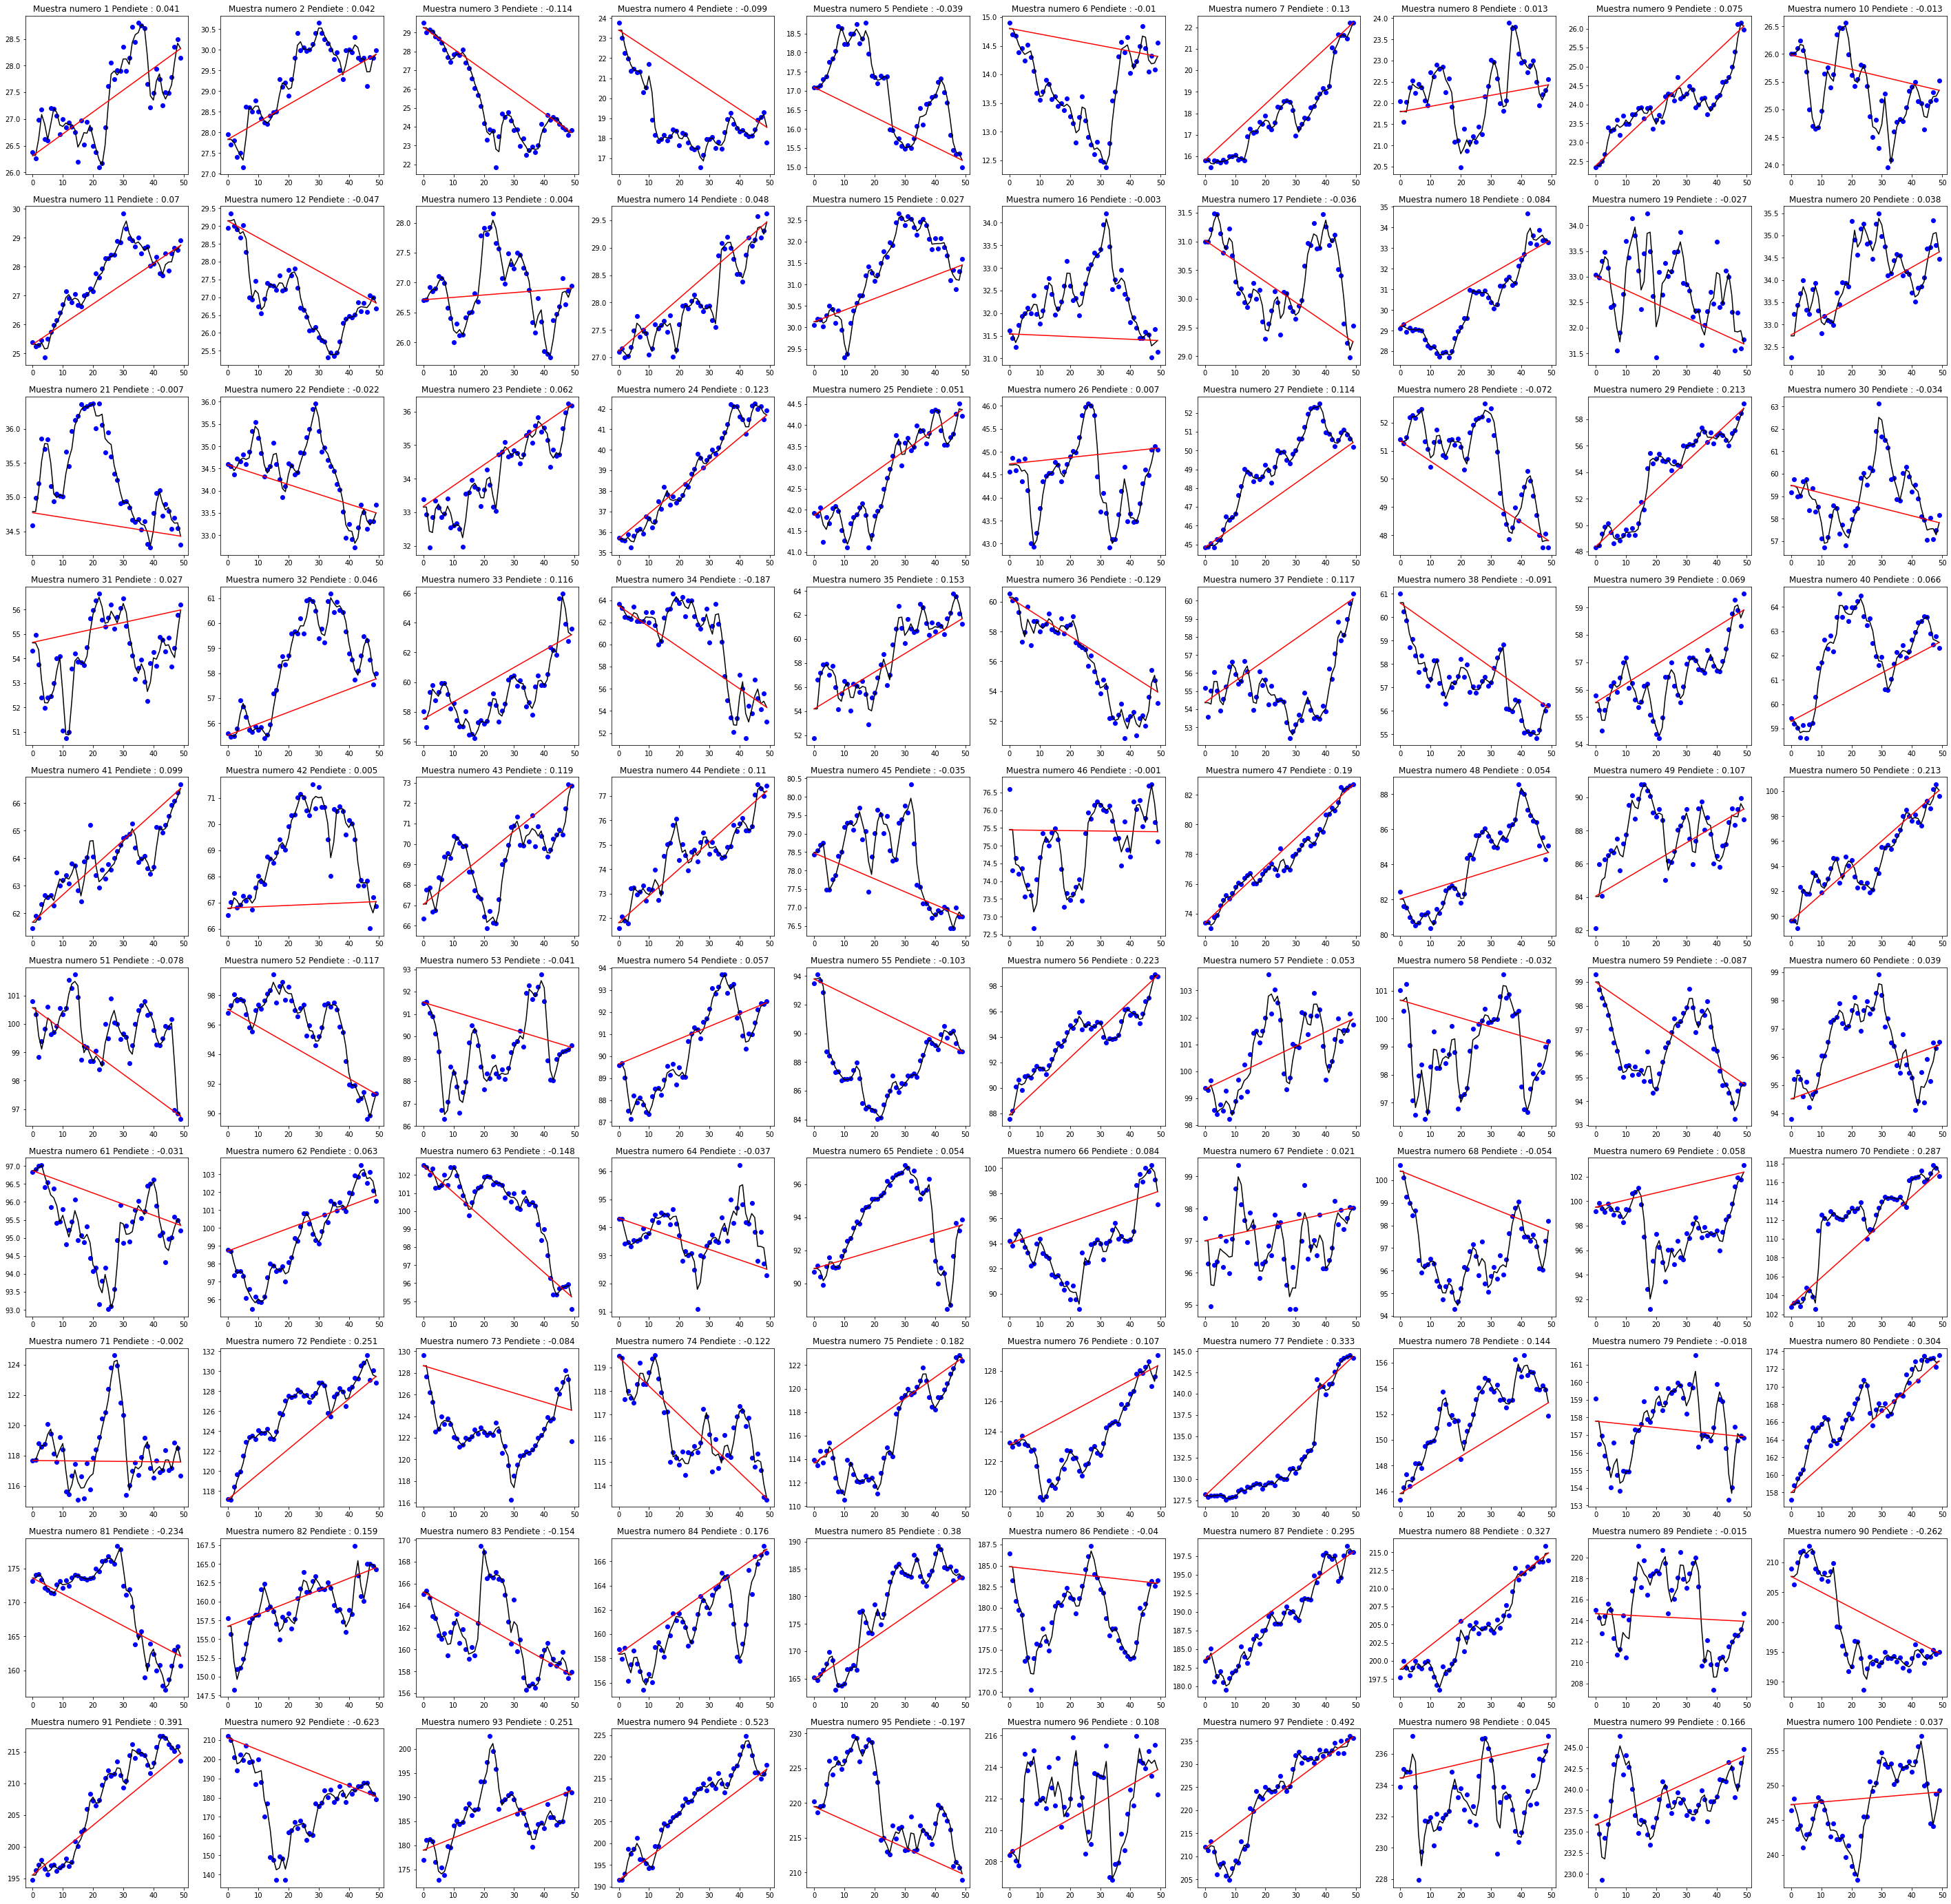

In [ ]:
n = len(muestras)
fig, axs = plt.subplots(10,int(n/10), figsize=(50,50))
indice = range(0,n,1)
X = np.array(list(range(50)))[:, np.newaxis]
pendientes = []

for i,muestra in zip(indice, muestras):
    y = np.array(muestra)[:, np.newaxis]
    regressor = neighbors.KNeighborsRegressor(2)
    regressor.fit(X,y)
    y_pred = regressor.predict(X)
    m = round(Pendiete(X,y_pred)[0],3)
    pendientes.append(m)
    tendencia = Recta_Tendencia(X,y_pred,m)    
    axs[int(i/10),i%10].scatter(X, y, c='b')
    axs[int(i/10),i%10].plot(X, y_pred, c='k')
    axs[int(i/10),i%10].plot(X, tendencia, c='r')
    axs[int(i/10),i%10].set_title('Muestra numero '+ 
                                 str(i+1) + ' Pendiete : ' + str(m))

Ahora graficamos las pendientes que obtuvimos de las muestras anteriores

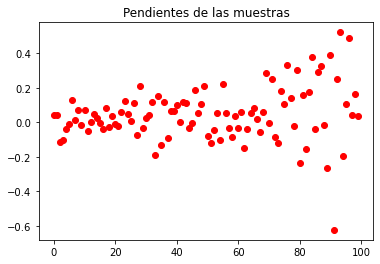

In [ ]:
plt.plot(pendientes,'ro')
plt.title('Pendientes de las muestras')
plt.show()

Podemos ver que hay pendientes positivas , negativas y unas muy cercanas a cero. Es decir que las pendientes positivas nos indican cuando la tendencia es creciente (es decir se vender) , cuando la tendencia es decreciente (ses decir se compra) y cuando la tendencia se mantiene (es decir no se compra ni se vende). Con lo que realizaremos la siguiente clasificiación de los datos. 

1. Si la pendiete es mayor a 0.007 la tendencia es creciente y se debe vender 
2. Si la pendiente es menor a -0.007 la tendencia es decreciente y se debe comprar 
3. Si la pendiente esta entre -0.007 y 0.007 la tendencia se mantiene y no se hace ninguna operación

En el siguiente código usamos las instrucciones anteriores para etiquetar los datos

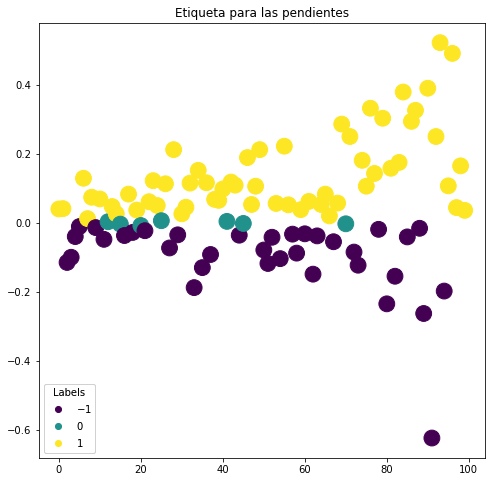

In [ ]:
labels = [-1 if(x < -0.007) else 1 if (x >0.007) else 0 for x in pendientes]
fig, axs = plt.subplots(1,1,figsize=(8,8))


scatter = axs.scatter(x = indice, y= pendientes, c = labels , s= 250)
axs.set_title('Etiqueta para las pendientes')
legend1 = axs.legend(*scatter.legend_elements(),
                    loc="lower left", title="Labels")
axs.add_artist(legend1)

Ahora utilizamos una maquina de aprendizaje como clasificador de tal manera que se reciba la serie de 50 datos y puede predecir si se compra , se vende, o no se realiza niguna operación. Es decir se trabaja en el espacio vectorial $R^{50}$, ya que a partir de estos 50 datos (de la muestra) se quiere decidir en la operación de trading que se va a hacer. Para realizar el clasificador partimos el conjunto de datos en entrenamiento (60%) , testo (20%) y validación (20%) de la siguiente manera y además realizamos la normalización de ellos para reducir costos computacionales

In [ ]:
#Normalización de los datos 
data = np.array(muestras)
labels = np.array(labels)
sc = MinMaxScaler()
data_norm = sc.fit_transform(data)
print(sc.get_params())
X_train, X_rest, y_train, y_rest = train_test_split(data_norm, labels, test_size=0.40)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.50)

{'clip': False, 'copy': True, 'feature_range': (0, 1)}


Ahora procedemos a entrenar el modelo con 3 modelos diferentes para ver cual de ellos tiene un mejor porcentaje de exactitud, para ello usamos el conjunto de entrenamiento para entrenar la maquina y el conjunto de validación para calcular la exactitud.

**Maquina de Soporte Vecotorial con Kernel polinomial**

In [ ]:
classifier1 =  SVC(kernel = 'poly')
classifier1.fit(X_train, y_train)
y_pred = classifier1.predict(X_val)
accuracy = accuracy_score(y_pred,y_val)
print(accuracy)

0.65


**Arbol de desición** 

In [ ]:
classifier2 = DecisionTreeClassifier(criterion='entropy', max_depth=8)
classifier2.fit(X_train, y_train)
y_pred = classifier2.predict(X_val)
accuracy = accuracy_score(y_pred,y_val)
print(accuracy)

0.45


**Proceso Gaussiano con Kernel de Base Radial**

In [ ]:
kernel = 1.0 * RBF(1.0)
classifier3 = GaussianProcessClassifier(kernel=kernel,random_state=0)
classifier3.fit(X_train, y_train)
y_pred = classifier3.predict(X_val)
accuracy = accuracy_score(y_pred,y_val)
print(accuracy)

0.9


**Red neuronal  con 100 capas y cada capa co 100 neuronas**

In [ ]:
classifier4 = MLPClassifier(activation = 'relu', hidden_layer_sizes =(100,100))
classifier4.fit(X_train, y_train)
y_pred = classifier4.predict(X_val)
accuracy = accuracy_score(y_pred,y_val)
print(accuracy)

0.8


Utilizando solamente la exactitud como metrica para establecer que tan bueno es el modelo, entonces podemos concluir que el mejor modelo en predecir las etiquetas del conjunto de validación es la red neuronal.Por lo que este clasificador será utilizado para predecir en el proximo paso. 

Ahora medimos la exacitud en el conjunto de testeo

In [ ]:
y_pred = classifier4.predict(X_test)
accuracy = accuracy_score(y_pred,y_test)
print(accuracy)

0.9


Es decir que tenemos un buen nivel de exactitud al momento de predecir si se compra, se vende o no se raliza niguna operación

# Programa para generar la clasificación

El siguiente algoritmo utiliza el calsificador escogido y realiza la clasificación entre comprar , vender o no operar. De tal manera que nos da una fecha en la que se debe efectuar la operacion que pronostica el clasificador

In [ ]:
def Classificacion(classifier,lista_precios,fecha):
    diccionario = {-1 : 'Vender', 1 : 'Comprar', 0: 'No operar'}
    N = len(lista_precios)
    data = np.array(lista_precios).reshape(-1,1)
    x_r = np.arange(0,N,1)
    sc1 = MinMaxScaler()
    data_norm = sc1.fit_transform(data)
    aux = range(0,N+1,50)
    i = 0
    precio = []
    eje_x = []
    label = []
    for muestra in range(0,len(aux)-1):
        X = (data_norm[aux[muestra]:aux[muestra+1]]).T
        y_pred = classifier.predict(X)
        operacion = diccionario[y_pred[0]]
        print (fecha[i] + ': ' + operacion) 
        precio.append(lista_precios[i])
        eje_x.append(x_r[i])
        label.append(y_pred[0])
        i = i+50 
    return precio, eje_x, label

valores, eje_x, label = Classificacion(classifier4,lista_precios, list(precio['Date']))

2002-01-28: Comprar
2002-04-10: Comprar
2002-06-20: Vender
2002-08-30: Vender
2002-11-11: Vender
2003-01-24: Vender
2003-04-07: Comprar
2003-06-18: Vender
2003-08-28: Comprar
2003-11-07: Vender
2004-01-22: Comprar
2004-04-02: Vender
2004-06-16: Vender
2004-08-26: Comprar
2004-11-05: Comprar
2005-01-19: Comprar
2005-04-01: Vender
2005-06-13: Comprar
2005-08-23: Vender
2005-11-02: Comprar
2006-01-17: Comprar
2006-03-29: Vender
2006-06-09: Comprar
2006-08-21: Comprar
2006-10-31: Comprar
2007-01-16: Comprar
2007-03-28: Comprar
2007-06-08: Vender
2007-08-20: Comprar
2007-10-30: Comprar
2008-01-11: Comprar
2008-03-26: Comprar
2008-06-05: Comprar
2008-08-15: Vender
2008-10-27: Comprar
2009-01-08: Vender
2009-03-23: Comprar
2009-06-03: Vender
2009-08-13: Comprar
2009-10-23: Comprar
2010-01-06: Comprar
2010-03-19: Comprar
2010-06-01: Comprar
2010-08-11: Comprar
2010-10-21: Vender
2011-01-03: Comprar
2011-03-16: Comprar
2011-05-26: Comprar
2011-08-08: Comprar
2011-10-18: Comprar
2011-12-29: Comp

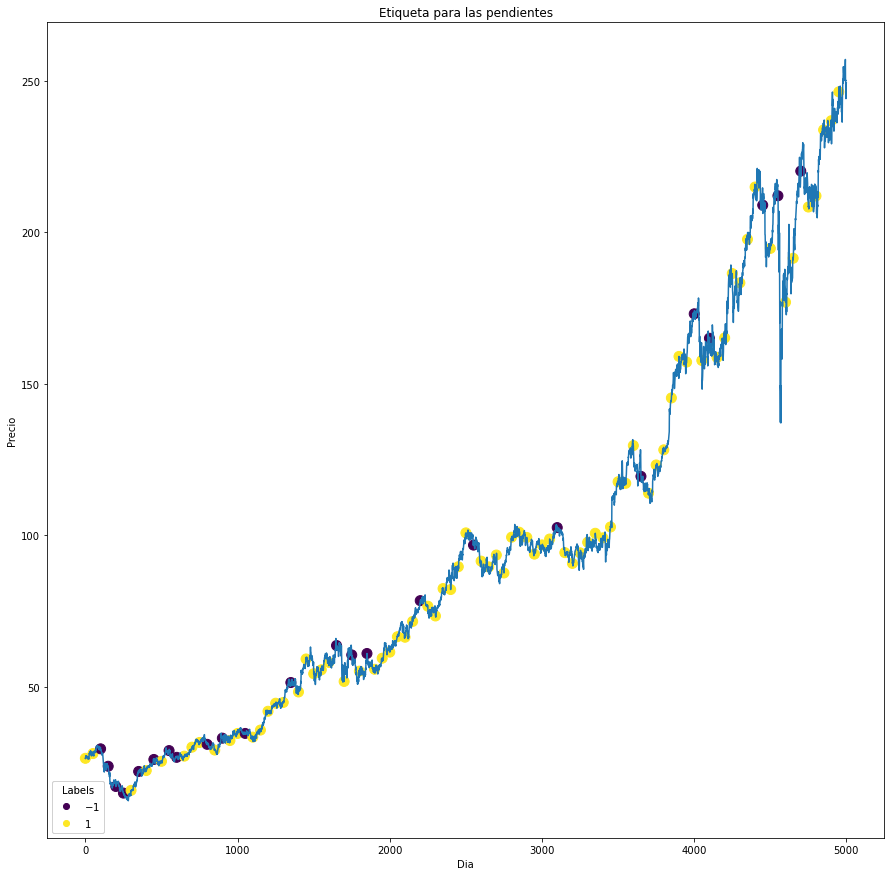

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,15))


scatter = axs.scatter(x = eje_x, y= valores, c = label , s= 100)
axs.set_title('Etiqueta para las pendientes')
legend1 = axs.legend(*scatter.legend_elements(),
                    loc="lower left", title="Labels")
axs.add_artist(legend1)
axs.set_xlabel('Dia')
axs.set_ylabel('Precio')
plt.plot(precio['Close'])

Es decir que en los puntos morados, el algoritmo nos indica que debemos vender, es decir que la tendencia es hacia abajo, mientras que en los puntos amarillos el algortimo nos dcie que compremos ya que al tendencia va creciendo.